# Historic comparison PV and wind

In this example we are examining the power feed-ins calculated by `atlite`. Based on data for capacity distributions and weather during the year 2013 in Germany, we try to match historical statistics.

In [1]:
import atlite
import xarray as xr
import pandas as pd
import scipy.sparse as sp
import numpy as np

import pgeocode
from collections import OrderedDict

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

### Download Necessary Data Files

1. We need to download the locations of all the PV installations in Germany to later
   tell atlite where to setup the PV panels and with which capacity.
   This information is available in Germany (thanks to the EEG feed-in-tariffs in
   the so-called "Anlagenregister").
2. We also download a reference time-series to compare our results against later.
   We retrieve the data from https://open-power-system-data.org which in return
   gets it from ENTSO-E.
3. Finally we also download a cutout of weather data from the ERA5 dataset containing
   Germany and the year we want to examine (2012).

In [3]:
import requests
import os
import zipfile

def download_file(url, local_filename):
    # variant of http://stackoverflow.com/a/16696317
    if not os.path.exists(local_filename):
        r = requests.get(url, stream=True)
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
    return local_filename

### Reference time-series

The reference is downloaded from [Open Power System Data (OPSD)](https://data.open-power-system-data.org/time_series/) and contains data reported by the
TSOs and DSOs.

In [4]:
opsd_fn = download_file('https://data.open-power-system-data.org/index.php?package=time_series&version=2019-06-05&action=customDownload&resource=3&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bfrom%5D=2012-01-01&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bto%5D=2013-05-01&filter%5BRegion%5D%5B%5D=DE&filter%5BVariable%5D%5B%5D=solar_generation_actual&filter%5BVariable%5D%5B%5D=wind_generation_actual&downloadCSV=Download+CSV',
                        'time_series_60min_singleindex_filtered.csv')

In [5]:
opsd = pd.read_csv(opsd_fn, parse_dates=True, index_col=0)

# we later use the (in current version) timezone unaware datetime64
# to work together with this format, we have to remove the timezone
# timezone information. We are working with UTC everywhere.

opsd.index = opsd.index.tz_convert(None)

# We are only interested in the 2012 data
opsd = opsd[("2011" < opsd.index) & (opsd.index < "2013")]

### PV locations ("Anlagenregister")

Download and unzip the archive containing all reported PV installations in Germany in 2011 from [energymap.info](http://www.energymap.info).

In [6]:
eeg_fn = download_file('http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip',
                        'eeg_anlagenregister_2015.08.utf8.csv.zip')

with zipfile.ZipFile(eeg_fn, "r") as zip_ref:
    zip_ref.extract("eeg_anlagenregister_2015.08.utf8.csv")

### Create a Cutout from ERA5

Load the country shape for Germany and determine its geographic bounds for downloading the appropriate cutout from ECMWF's ERA5 data set.

In [7]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd
shp = shpreader.Reader(shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries'))
de_record = list(filter(lambda c: c.attributes['ISO_A2'] == 'DE', shp.records()))[0]
de = pd.Series({**de_record.attributes, 'geometry':de_record.geometry})
x1, y1, x2, y2 = de['geometry'].bounds

/home/fabian/.miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [8]:
cutout = atlite.Cutout('germany-2012',
                       module='era5',
                       x=slice(x1-.2,x2+.2), y=slice(y1-.2, y2+.2), 
                       chunks={'time':100},
                       time="2012")

/home/fabian/vres/py/atlite/atlite/cutout.py:187: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


In [9]:
cutout.prepare()

<Cutout "germany-2012">
 x = 5.75 ⟷ 15.00, dx = 0.25
 y = 47.25 ⟷ 55.25, dy = 0.25
 time = 2012-01-01 ⟷ 2012-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

*Downloading the cutout can take a few seconds or even an hour, depending on your internet connection and whether the dataset
was recently requested from the data set provider (and is thus cached on their premise).
For us this took ~2 minutes the first time. Preparing it again (a second time) is snappy (for whatever reason you would want to download the same cutout twice).*

### Generate capacity layout

The capacity layout represents the installed generation capacities in MW in each of the cutout's grid cells.
For this example we have generation capacities in kW on a postal code (and partially even more detailed) level.
Using the following function, we load the data, fill in geocoordinates where missing for all capacities. 

Below, the resulting capacities are dissolved to the grid raster using the function `Cutout.layout_from_capacity_list`. The dissolving is done by aggregating the capacities
to their respective closest grid cell center obtained from the `cutout.grid`.

In [10]:
def load_capacities(typ, cap_range=None, until=None):
    """Read in and select capacities.
    
    Parameters
    ----------
        typ : str
            Type of energy source, e.g. "Solarstrom" (PV), "Windenergie" (wind).
        cap_range : (optional) list-like
            Two entries, limiting the lower and upper range of capacities (in kW)
            to include. Left-inclusive, right-exclusive.
        until : str
            String representation of a datetime object understood by pandas.to_datetime()
            for limiting to installations existing until this datetime.
        
    """
    
    # Load locations of installed capacities and remove incomplete entries
    cols = OrderedDict((('installation_date', 0),
                        ('plz', 2), ('city', 3),
                        ('type', 6),
                        ('capacity', 8), ('level', 9),
                        ('lat', 19), ('lon', 20),
                        ('validation', 22)))
    database = pd.read_csv('eeg_anlagenregister_2015.08.utf8.csv',
                       sep=';', decimal=',', thousands='.',
                       comment='#', header=None,
                       usecols=list(cols.values()),
                       names=list(cols.keys()),
                       # German postal codes can start with '0' so we need to treat them as str
                       dtype={'plz':str},
                       parse_dates=['installation_date'],
                       infer_datetime_format=True,
                       na_values=('O04WF', 'keine'))

    database = database[(database['validation'] == 'OK') & (database['plz'].notna())]

    # Query postal codes <-> coordinates mapping
    de_nomi = pgeocode.Nominatim('de')
    plz_coords = de_nomi.query_postal_code(database['plz'].unique())
    plz_coords = plz_coords.set_index('postal_code')

    # Fill missing lat / lon using postal codes entries
    database.loc[database['lat'].isna(), 'lat'] = database['plz'].map(plz_coords['latitude'])
    database.loc[database['lon'].isna(), 'lon'] = database['plz'].map(plz_coords['longitude'])

    # Ignore all locations which have not be determined yet
    database = database[database['lat'].notna() & database['lon'].notna()]
        
    # Select data based on type (i.e. solar/PV, wind, ...)
    data = database[database['type'] == typ].copy()
    
    # Optional: Select based on installation day
    if until is not None:
        data = data[data['installation_date'] < pd.to_datetime(until)]
    
    # Optional: Only installations within this caprange (left inclusive, right exclusive)
    if cap_range is not None:
        data = data[(cap_range[0] <= data['capacity']) & (data['capacity'] < cap_range[1])]
    
    data['capacity'] = data.capacity / 1e3 # convert to MW
    return data.rename(columns={'lon':'x', 'lat': 'y'})


## Examine Solar Feed-Ins 

The layout defines the production capacity per grid cell. Let's see how it looked like in 2012. 

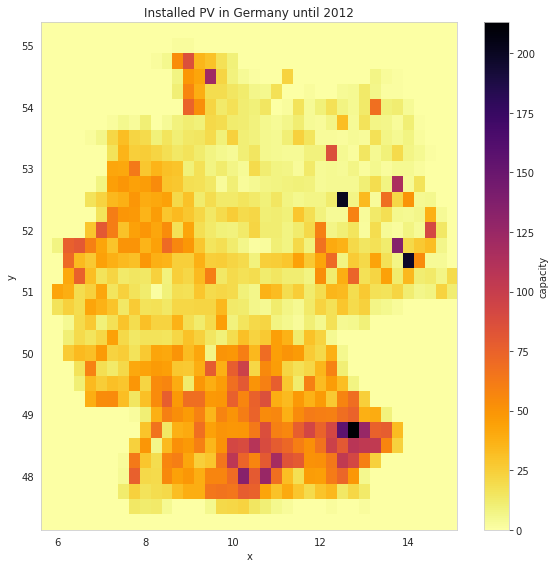

In [11]:
capacities = load_capacities('Solarstrom', until="2012")
solar_layout = cutout.layout_from_capacity_list(capacities, col='capacity')

solar_layout.plot(cmap="inferno_r", size=8, aspect=1)
plt.title("Installed PV in Germany until 2012")
plt.tight_layout()

What did the total production of this capacity distribution looked like? We pass the layout to the conversion function `cutout.pv`. This calculates the total production over the year. We assume a south orientation (`"azimuth": 180.`) and prominent slope 30-35° for PV in Germany (`"slope":30.`)

In [12]:
pv = cutout.pv(panel="CSi", orientation={'slope': 30., 'azimuth': 180.}, layout=solar_layout)

As OPSD also provides data on the total production, let's compare those two.

In [13]:
pv.squeeze().to_series()

time
2012-01-01 00:00:00    0.0
2012-01-01 01:00:00    0.0
2012-01-01 02:00:00    0.0
2012-01-01 03:00:00    0.0
2012-01-01 04:00:00    0.0
                      ... 
2012-12-31 19:00:00    0.0
2012-12-31 20:00:00    0.0
2012-12-31 21:00:00    0.0
2012-12-31 22:00:00    0.0
2012-12-31 23:00:00    0.0
Name: specific generation, Length: 8784, dtype: float64

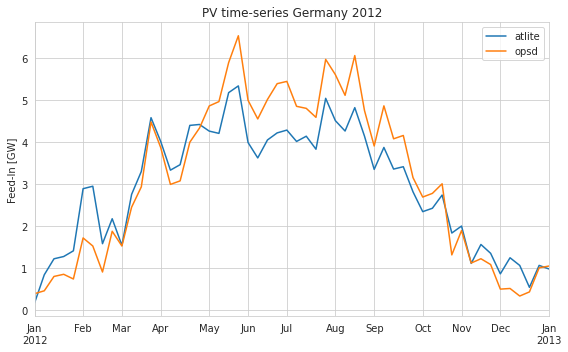

In [14]:
compare = pd.DataFrame(dict(atlite=pv.squeeze().to_series(), opsd=opsd['DE_solar_generation_actual'])) /1e3 # in GW
compare.resample('1W').mean().plot(figsize=(8,5))
plt.ylabel("Feed-In [GW]")
plt.title('PV time-series Germany 2012')
plt.tight_layout()

`atlite` also supports to set an **optimal slope** of the panels, using the formula documented in http://www.solarpaneltilt.com/#fixed. The production then looks like:

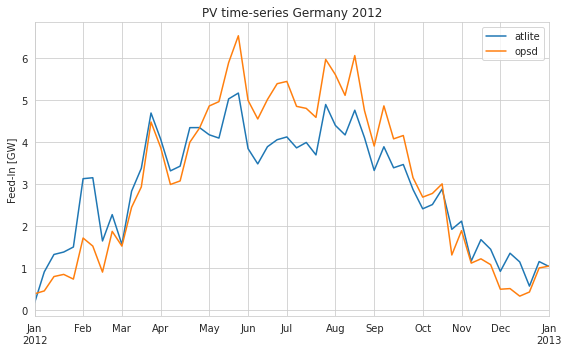

In [15]:
pv_opt = cutout.pv(panel="CSi", orientation='latitude_optimal', layout=solar_layout)
compare_opt = pd.DataFrame(dict(atlite=pv_opt.squeeze().to_series(), opsd=opsd['DE_solar_generation_actual']))/1e3 # in GW
compare_opt.resample('1W').mean().plot(figsize=(8,5))
plt.ylabel("Feed-In [GW]")
plt.title('PV time-series Germany 2012')
plt.tight_layout()

How about zooming in? Let's plot a specific week. We see that the peaks are differing a bit. In this case `atlite` alternates between over and underestimating a bit... but not too bad given the fact that we are using a reanalysis dataset.

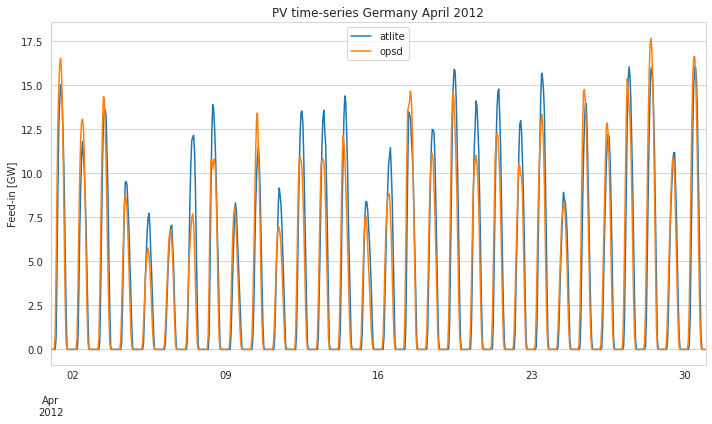

In [16]:
compare_opt.loc["2012-04"].plot(figsize=(10,6))
plt.ylabel('Feed-in [GW]')
plt.title('PV time-series Germany April 2012')
plt.tight_layout()

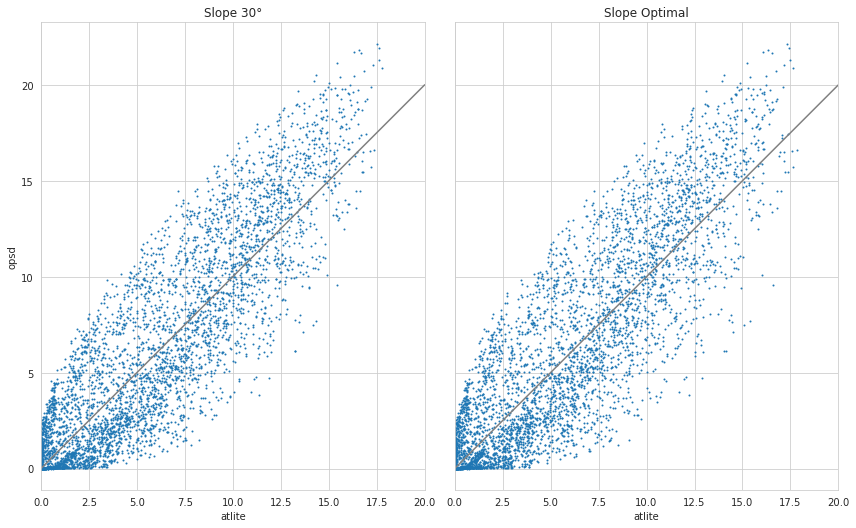

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, subplot_kw={'aspect': 'equal', 'xlim':[0,20]}, figsize=(12,16), sharey=True)
compare.plot(x='atlite', y='opsd', kind='scatter', s=1, ax=ax1, title='Slope 30°')
compare_opt.plot(x='atlite', y='opsd', kind='scatter', s=1, ax=ax2, title='Slope Optimal')

ax1.plot([0,20],[0,20], c='gray')
ax2.plot([0,20],[0,20], c='gray')
plt.tight_layout()

Let's look at the duration curves of the 30° slope pv timeseries.

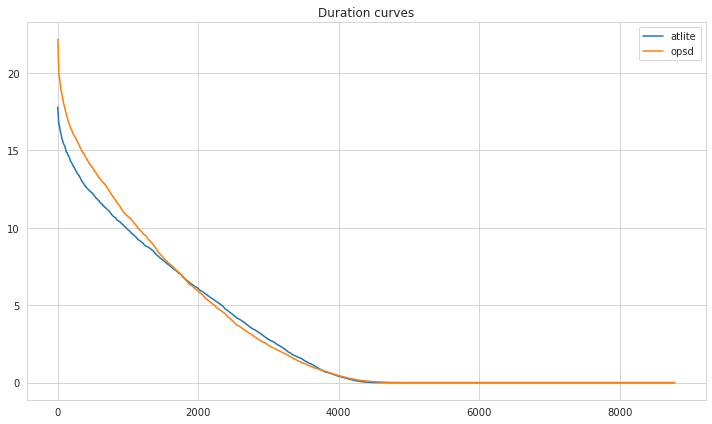

In [18]:
compare['atlite'].sort_values(ascending=False).reset_index(drop=True).plot(figsize=(10,6))
compare['opsd'].sort_values(ascending=False).reset_index(drop=True).plot(figsize=(10,6))
plt.legend()
plt.title('Duration curves')
plt.tight_layout()

## Examine Wind Feed-Ins

Now we want to examine the wind potentials in Germany for year 2012. 

These wind turbines are available in atlite. 

In [19]:
for t in atlite.windturbines: print(f'* {t}')

* Vestas_V80_2MW_gridstreamer
* Bonus_B1000_1000kW
* NREL_ReferenceTurbine_5MW_offshore
* Enercon_E101_3000kW
* Vestas_V25_200kW
* Siemens_SWT_107_3600kW
* Vestas_V66_1750kW
* Enercon_E82_3000kW
* Vestas_V164_7MW_offshore
* Vestas_V112_3MW_offshore
* Suzlon_S82_1.5_MW
* Vestas_V47_660kW
* Vestas_V112_3MW
* Siemens_SWT_2300kW
* Enercon_E126_7500kW
* Vestas_V90_3MW


We define capacity range to roughly match the wind turbine type. 

In [20]:
turbine_categories = [
        dict(name='Vestas_V25_200kW', up=400.),
        dict(name='Vestas_V47_660kW', up=700.),
        dict(name='Bonus_B1000_1000kW', up=1100.),
        dict(name='Suzlon_S82_1.5_MW', up=1600.),
        dict(name='Vestas_V66_1750kW', up=1900.),
        dict(name='Vestas_V80_2MW_gridstreamer', up=2200.),
        dict(name='Siemens_SWT_2300kW', up=2500.),
        dict(name='Vestas_V90_3MW', up=50000.)
    ]


In [ ]:
low = 0
for index, turbine_cat in enumerate(turbine_categories):
    
    capacities = load_capacities('Windkraft', cap_range=[low,turbine_cat['up']], until="2012")
    layout = cutout.layout_from_capacity_list(capacities, 'capacity')
    
    turbine_categories[index]['layout'] = layout
    low = turbine_cat['up']

We create a layout for each capacity range, each with a different windturbine model

In [ ]:
wind = xr.Dataset()
for turbine_cat in turbine_categories:
    name = f"< {turbine_cat['up']} kW"
    wind[name] = cutout.wind(turbine=turbine_cat['name'], layout=turbine_cat['layout'], show_progress=False)
    
wind['total'] = sum(wind[c] for c in wind)
wind

Again, let's compare the result with the feed-in statistics from OPSD. We add an extra column for wind turbines with capacity lower than 1600 kW

In [ ]:
compare = pd.DataFrame({"atlite":wind['total'].squeeze().to_series(),
                            "< 1600 kW":wind['< 1600.0 kW'].squeeze().to_series(),
                            "opsd":opsd['DE_wind_generation_actual']})

compare = compare/1e3 # in GW

In [ ]:
compare.resample('1W').mean().plot(figsize=(10,6))
plt.ylabel('Feed-in [GW]')
plt.title('Wind time-series Germany 2012')
plt.tight_layout()

In [ ]:
compare.loc["2012-04"].plot(figsize=(10,6))
plt.ylabel('Feed-in [GW]')
plt.title('Wind time-series Germany April 2012')
plt.tight_layout()

In [ ]:
ax = compare.plot(x='atlite', y='opsd', kind='scatter', figsize=(12,8))
ax.set_aspect('equal')
ax.set_xlim(0,30)
ax.plot([0,30],[0,30],c='gray')
plt.tight_layout()

In [ ]:
compare['atlite'].sort_values(ascending=False).reset_index(drop=True).plot(figsize=(10,6))
compare['opsd'].sort_values(ascending=False).reset_index(drop=True).plot(figsize=(10,6))
plt.legend()
plt.title('Duration curves')
plt.ylabel('Wind Feed-in [GW]')
plt.xlabel('Accumulated hours')
plt.tight_layout()

Looks quite aggreeable!

## Splitting time-series into shapes

The generation time-series can also be aggregated based on shapes.
In this example, we aggregate on the basis of the German "Laender" (federal states).

In [ ]:
shp = shpreader.Reader(shpreader.natural_earth(resolution='10m',
                                               category='cultural',
                                               name='admin_1_states_provinces'))
de_records = list(filter(lambda r: r.attributes['iso_3166_2'].startswith('DE'), shp.records()))
laender = gpd.GeoDataFrame([{**r.attributes, 'geometry':r.geometry} for r in de_records])\
             .rename(columns={"iso_3166_2":"state"}).set_index("state")

In [ ]:
x1, y1, x2, y2 = de['geometry'].bounds

In [ ]:
print(type(laender.loc['DE-TH'].geometry))
laender.loc['DE-TH']

In [ ]:
pv = cutout.pv(panel="CSi", orientation={'slope': 30., 'azimuth': 0.},
               shapes=laender['geometry'],
               layout=solar_layout)

In [ ]:
pv.sel(state=['DE-TH', 'DE-BY']).to_pandas().resample('1W').mean().plot(figsize=(10,6))